# USR 5K

https://www.usr5k.org/results-1

## Web Scraping and Data Cleaning

### Imports

In [110]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
import numpy as np
import re
import seaborn as sns

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

### Data

In [2]:
race_results = {2001:'http://legacy.compuscore.com/cs2001/novdec/meighan1.htm#overall',
                2002:'http://legacy.compuscore.com/cs2002/novdec/meighan1.htm#overall',
                2003:'',
                2004:'http://legacy.compuscore.com/cs2004/novdec/meighan1.htm',
                2005:'http://legacy.compuscore.com/cs2005/novdec/meighan1.htm',
                2006:'http://legacy.compuscore.com/cs2006/novdec/meighan1.htm',
                2007:'http://legacy.compuscore.com/cs2007/novdec/meighan1.htm',
                2008:'http://legacy.compuscore.com/cs2008/novdec/meighan1.htm',
                2009:'http://legacy.compuscore.com/cs2009/novdec/meighanchiptime.htm',
                2010:'http://legacy.compuscore.com/cs2010/novdec/meighan.htm',
                2011:'http://legacy.compuscore.com/cs2011/novdec/meighan.htm',
                2012:'http://legacy.compuscore.com/cs2012/novdec/meighan.htm',
                2013:'http://legacy.compuscore.com/cs2013/novdec/meighan.htm',
                2014:'http://legacy.compuscore.com/cs2014/novdec/usr5k.htm',
                2015:'http://legacy.compuscore.com/cs2015/novdec/usr5k.htm',
                2016:'http://legacy.compuscore.com/cs2016/novdec/usr5k.htm',
                2017:'http://legacy.compuscore.com/cs2017/novdec/usr5k.htm',
                2018:'https://my.raceresult.com/112533/',
                2019:'https://my.raceresult.com/143177/results?lang=en#0_CBB879',
                2021:'https://my.raceresult.com/186640/#1_07B109',
                2022:'https://my.raceresult.com/225567/#1_61E9DE',
                2023:'https://my.raceresult.com/269161/results#1_61E9DE'}

### Helper Functions

In [4]:
def clean(df, year):
    df['place'] = df[0].str[:5]
    df = df[~df['place'].str.contains('\r')]
    df['name'] = df[0].str[5:26]
    df['citystate'] = df[0].str[26:45]
    df[['city','state']] = df['citystate'].str.split(",", n=1, expand=True)
    df['age'] = df[0].str[45:48]
    df['gender'] = df[0].str[48:49]
    if year < 2010:
        df['time'] = df[0].str[52:59]
    else:
        df['time'] = df[0].str[52:63]
    df = df.drop(columns=[0, 'citystate'])
    df['year'] = year
    return df
    
def scrape(url, colList):
    page = urlopen(url)
    html = page.read().decode("utf-8")
    soup = BeautifulSoup(html, "html.parser")
    text = soup.find_all(string=True)
    text = list( text[i] for i in colList)
    text = "".join(text)
    text = text.split("\n")
    df = pd.DataFrame(text)
    return df

def jsscrape(year):
    service = Service()
    options = webdriver.ChromeOptions()
    options.add_argument("--headless=new")
    driver = webdriver.Chrome(service=service, options=options)

    driver.get(race_results.get(year))
    WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, "#tb_1Data"))
    )

    soup = BeautifulSoup(driver.page_source, "html.parser")
    text = soup.find_all(string=True)
    text[:] = [x for x in text if x != '\n']
    return text

###  Compuscore Data

In [55]:
#2009
page = urlopen(race_results.get(2009))
html = page.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")
text = soup.find_all(string=True)
df = pd.DataFrame(text)
data = df.iloc[20, 0]
data = data.split("\n")
df = pd.DataFrame(data)
df[['place','raw']] = df[0].str.split(".", n=1, expand=True)
df['name'] = df['raw'].str[:21]
df['citystate'] = df['raw'].str[21: 39]
df[['city','state']] = df['citystate'].str.split(",", n=1, expand=True)
df['age'] = df['raw'].str[39:42]
df['gender'] = df['raw'].str[42:44]
df['time'] = df['raw'].str[58:67]
df['year'] = 2009
master0 = df.drop(columns=[0, 'raw', 'citystate'])

#2001
url = race_results.get(2001)
page = urlopen(url)
html = page.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")
text = soup.find_all(string=True)
df = pd.DataFrame(text)
df['length'] = df[0].str.len()
df = df[df['length'] > 2000]
data = df.iloc[0, 0]
temp = data.split("\n")
df = clean(pd.DataFrame(temp), 2001)
master0 = pd.concat([master0, df])

#2002, 2004-2008, 2010-2017
years = [2002, 2004, 2005, 2006, 2007, 2008, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
colLists = [[*range(83, 83 + 12*21, 21)],
            [*range(84, 84 + 16*21, 21)], 
            [*range(84, 84 + 16*21, 21)],
            [*range(83, 83 + 17*21, 21)],
            [*range(84, 84 + 18*21, 21)],
            [*range(113, 113 + 21*21, 21)],
            [*range(116, 116 + 18*21, 21)],
            [*range(112, 112 + 17*25, 25)],
            [*range(115, 115 + 17*25, 25)],
            [*range(115, 115 + 19*25, 25)],
            [*range(111, 111 + 19*25, 25)],
            [*range(108, 108 + 19*25, 25)],
            [*range(107, 107 + 16*25, 25)],
            [*range(109, 109 + 17*25, 25)]  
           ]
cols = {years[i]: colLists[i] for i in range(len(years))}
for e in years:
    url = race_results.get(e)
    colList = cols.get(e)
    df = clean(scrape(url, colList), e)
    master0 = pd.concat([master0, df], ignore_index=True)

### Raceresults Data

In [6]:
#2018
text = jsscrape(2018)
idx = text.index('1.')
idx2 = text.index('Number of records: 1779')
text = text[idx:idx2]
place = text[::12]
bib = text[1::12]
name = text[2::12]
city = text[3::12]
gender = text[4::12]
age = text[5::12]
ag_place = text[6::12]
time = text[7::12]
pace = text[9::12]
dict = {'place':place, 'bib':bib, 'name':name, 'city':city, 'gender':gender, 'age':age, 'ag_place':ag_place,
        'time':time} 
df2018 = pd.DataFrame(dict)
df2018['year'] = 2018

#2019
text = jsscrape(2019)
idx = text.index('1.')
idx2 = text.index('Number of records: 2183')
text = text[idx:idx2]
place = text[::13]
bib = text[1::13]
name = text[2::13]
city = text[3::13]
gender = text[4::13]
age = text[5::13]
ag_place = text[6::13]
time = text[7::13]
pace = text[8::13]
dict = {'place':place, 'bib':bib, 'name':name, 'city':city, 'gender':gender, 'age':age, 'ag_place':ag_place,
        'time':time} 
df2019 = pd.DataFrame(dict)
df2019['year'] = 2019

#2021
text = jsscrape(2021)
idx = text.index('1.')
idx2 = text.index('Number of records: 1917')
text = text[idx:idx2]
place = text[::12]
bib = text[1::12]
name = text[2::12]
city = text[3::12]
gender = text[4::12]
age = text[5::12]
ag_place = text[6::12]
time = text[7::12]
pace = text[8::12]
dict = {'place':place, 'bib':bib, 'name':name, 'city':city, 'gender':gender, 'age':age, 'ag_place':ag_place,
        'time':time} 
df2021 = pd.DataFrame(dict)
df2021['year'] = 2021

#2022
text = jsscrape(2022)
idx = text.index('1')
idx2 = text.index('Number of records: 1878')
text = text[idx:idx2]
place = text[::11]
name = text[1::11]
time = text[2::11]
pace = text[3::11]
gender = text[5::11]
ag_place = text[4::11]
bib = text[8::11]
dict = {'place':place, 'bib':bib, 'name':name, 'gender':gender, 'ag_place':ag_place, 'time':time} 
df2022 = pd.DataFrame(dict)
df2022['year'] = 2022

#2023
text = jsscrape(2023)
idx = text.index('1')
idx2 = text.index('Number of records: 2079')
text = text[idx:idx2]
place = text[::11]
name = text[1::11]
time = text[2::11]
pace = text[3::11]
gender = text[5::11]
ag_place = text[4::11]
bib = text[8::11]
dict = {'place':place, 'bib':bib, 'name':name, 'gender':gender, 'ag_place':ag_place, 'time':time} 
df2023 = pd.DataFrame(dict)
df2023['year'] = 2023

### Combining Dataframes

In [87]:
master = pd.concat([df2018, df2019, df2021, df2022, df2023], ignore_index=True)
master = master.drop(columns=['bib', 'ag_place'])
master = pd.concat([master, master0])

master['place'] = master['place'].str.strip()
master['name'] = master['name'].str.strip()
master['gender'] = master['gender'].str.strip()
master['age'] = master['age'].str.strip()
master['time'] = master['time'].str.strip()
master['state'] = master['state'].str.strip()

master = master[master['time'].str.len() > 4]

master.index = pd.RangeIndex(len(master.index))

mask = (master['time'].str.len() == 5)
master.loc[mask, 'time'] = '0:' + master['time'].astype(str)

master = master[master['name'] != 'Not Registered']
master = master[master['name'] != 'Unofficial Finisher']

master['place'] = master['place'].map(lambda x: x.rstrip('.'))
master['gender'] = master['gender'].str.upper()
master = master.fillna('')

ValueError: invalid literal for int() with base 10: ''

## Results

### Top 20 Male Runners of All Time

In [84]:
sort = master[master['gender'] == 'M']
sort = sort.sort_values(by=['time'], ascending=True)
sort.head(20)

,place,name,city,gender,age,time,year,state
26608,1,Kevin Cooper,Providence,M,24,0:15:02,2014,RI
15671,1,Richard Yeats,Providence,M,21,0:15:12,2007,RI
7757,1,Amiri Whittle,,M,,0:15:16.3,2023,
22235,1,Rob Nihen,Glen Rock,M,24,0:15:21,2012,NJ
14840,1,Richard Yeats,Providence,M,20,0:15:23,2006,RI
32915,1,Rob Albano,Mahwah,M,27,0:15:24,2017,NJ
28461,1,Rob Albano,Pompton Plains,M,25,0:15:24,2015,NJ
26609,2,Christian Costello,Ridgewood,M,20,0:15:29,2014,NJ
24483,1,Michael Fonder,Plainsboro,M,27,0:15:29,2013,NJ
30937,1,Rob Albano,Mahwah,M,26,0:15:30,2016,NJ


### Top 20 Female Runners of All Time

In [88]:
sort = master[master['gender'] == 'F']
sort = sort.sort_values(by=['time'], ascending=True)
sort.head(20)

,place,name,city,gender,age,time,year,state
20134,15,Amy Van Alstine,Midland Park,F,24,0:16:50,2011,NJ
24493,11,Sarah Pagano,Ringwood,F,22,0:17:01,2013,NJ
1791,13,Josette Norris,Charlottesville,F,23,0:17:06,2019,
32926,12,Josette Norris,Tenafly,F,21,0:17:33,2017,NJ
32930,16,Abby Mclaughlin,Waldwick,F,19,0:17:47,2017,NJ
9856,21,Amy Van Alstine,Midland Park,F,22,0:17:54,2009,NJ
24503,21,Molly Higgins,Randolph,F,21,0:17:58,2013,NJ
20158,39,Molly Higgins,Randolph,F,19,0:18:09,2011,NJ
9866,31,Sheila Casey,Park Ridge,F,40,0:18:14,2009,NJ
5897,19,Abigail Taylor,,F,,0:18:16.0,2022,


### Top 20 Male Runners U18

In [91]:
sort = master
sort['age'] = pd.to_numeric(sort['age'])
sort = sort[sort['gender'] == 'M']
sort = sort[sort['age'] < 18]
sort = sort.sort_values(by=['time'], ascending=True)
sort.head(20)

,place,name,city,gender,age,time,year,state
1783,5,Steven Bello,Westwood,M,17.0,0:16:07,2019,
13930,4,Ben Diestel,Allendale,M,17.0,0:16:15,2005,NJ
11619,5,Robert Kuhn,Delmar,M,17.0,0:16:37,2001,NY
13048,7,Will Nowicki,Hillsdale,M,16.0,0:16:44,2004,NJ
14848,9,Andrew Gaidus,Upper Saddle Ri,M,17.0,0:16:46,2006,NJ
14852,13,Tom Mulligan,Pearl River,M,15.0,0:16:54,2006,NY
26623,16,Quinn Geraghty,Bogota,M,17.0,0:16:55,2014,NJ
15677,7,Patrick Rochford,Bogota,M,16.0,0:16:57,2007,NJ
13935,9,Nikolajs Batarags,Upper Saddle Ri,M,17.0,0:16:57,2005,NJ
13936,10,Will Nowicki,Hillsdale,M,17.0,0:16:59,2005,NJ


In [ ]:
### Top 20 Female Runners U18

In [92]:
sort = master
sort['age'] = pd.to_numeric(sort['age'])
sort = sort[sort['gender'] == 'F']
sort = sort[sort['age'] < 18]
sort = sort.sort_values(by=['time'], ascending=True)
sort.head(20)

,place,name,city,gender,age,time,year,state
12350,29,Caitlin Smyth,Upper Saddle Ri,F,17.0,0:19:03,2002,NJ
30965,29,Camryn Wennersten,Ridgewood,F,12.0,0:19:05,2016,NJ
28508,48,Anna George,Montville,F,15.0,0:19:25,2015,NJ
32958,44,Camryn Wennerstein,Ridgewood,F,13.0,0:19:30,2017,NJ
11654,40,Caitlin Smyth,Upper Saddle Ri,F,16.0,0:19:45,2001,NJ
4001,40,Rebecca MacLaren,HO HO KUS,F,15.0,0:19:48.2,2021,
28526,66,Michelle Sidor,Upper Saddle Ri,F,15.0,0:19:57,2015,NJ
26677,70,Michelle Sidor,Upper Saddle Ri,F,14.0,0:19:58,2014,NJ
28527,67,Camryn Wennersten,Ridgewood,F,11.0,0:20:00,2015,NJ
4006,45,Brianna Potaki,Wyckoff,F,14.0,0:20:05.2,2021,


In [ ]:
### Top 20 Male Runners Seniors

In [94]:
sort = master
sort['age'] = pd.to_numeric(sort['age'])
sort = sort[sort['gender'] == 'M']
sort = sort[sort['age'] > 64]
sort = sort[sort['age'] != 99]
sort = sort.sort_values(by=['time'], ascending=True)
sort.head(20)

,place,name,city,gender,age,time,year,state
11735,121,Michael Goldman,Scarsdale,M,65.0,0:21:58,2001,NY
20288,169,Bob Roemer,Paramus,M,65.0,0:22:15,2011,NJ
31083,147,Phil Whittington,Palisades Park,M,65.0,0:22:16,2016,NJ
12446,125,Michael Goldman,Scarsdale,M,66.0,0:22:35,2002,NY
14078,152,Raymond Bondy,Wyckoff,M,66.0,0:22:36,2005,NJ
15026,187,Raymond Bondy,Wyckoff,M,67.0,0:22:55,2006,NJ
4125,164,Richard Lee,Mahwah,M,65.0,0:23:07.5,2021,
15886,216,Raymond Bondy,Wyckoff,M,68.0,0:23:09,2007,NJ
13229,188,Raymond Bondy,Mahwah,M,65.0,0:23:14,2004,NJ
12501,180,Harvey Strauss,New York,M,65.0,0:23:28,2002,NY


In [ ]:
### Top 20 Female Runners Seniors

In [103]:
sort = master
sort['age'] = pd.to_numeric(sort['age'])
sort = sort[sort['gender'] == 'F']
sort = sort[sort['age'] > 64]
sort = sort[sort['age'] < 90]
sort = sort.sort_values(by=['time'], ascending=True)
sort.head(20)

,place,name,city,gender,age,time,year,state
11936,322,Toshiko D'elia,Ridgewood,F,71.0,0:26:16,2001,NJ
12725,404,Toshiko D'elia,Ridgewood,F,72.0,0:27:53,2002,NJ
13557,516,Toshiko D'elia,Ridgewood,F,74.0,0:28:38,2004,NJ
19016,767,Marissa Romano,Hasbrouck Heigh,F,77.0,0:28:44,2010,NJ
31672,736,Norma Grace,New Orleans,F,68.0,0:28:58,2016,LA
31685,749,Helen Damiano,Ramsey,F,69.0,0:29:01,2016,NJ
4707,746,Barbara Lankelis,Mahwah,F,68.0,0:30:16.9,2021,
33966,1052,Helen Damiano,Ramsey,F,70.0,0:30:31,2017,NJ
778,779,Helen Damiano,Ramsey,F,71.0,0:30:41,2018,
10880,1045,Dorothy Murphy,Airmont,F,65.0,0:31:09,2009,NY


### Most Frequent Racers

In [98]:
master['name'].value_counts().nlargest(25)

name
Michael Paolazzi    21
Kevin Cole          20
Richard Lee         20
Mark Polizzi        20
Tim Ryan            19
Hector Martinez     19
Chris Paolazzi      19
Laura White         19
Mary Barr           19
John Horuzy         18
Nick Paolazzi       18
Sean Bookstaver     18
Greg Verhoff        18
Mary Flannery       18
Kevin Martin        17
Stuart Barr         17
Cindy Spence        17
Tahir Qadeer        17
Eric Seem           17
Ryan Warnock        17
Gerard Maron        16
Jennifer Glick      16
Virginia Shea       16
Karen Esterow       16
Andrew Schechter    16
Name: count, dtype: int64

### Participation Over the Years

<Axes: xlabel='year', ylabel='name'>

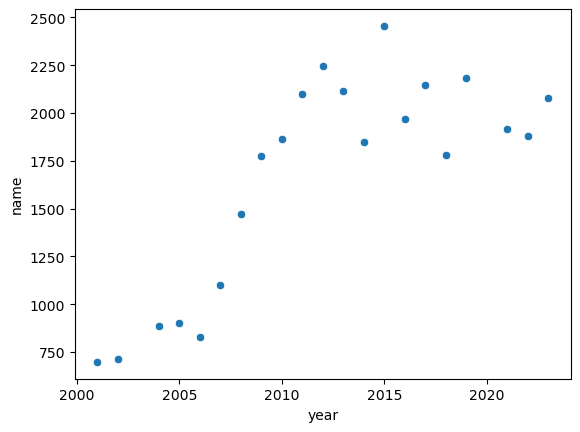

In [111]:
results = master.groupby(['year']).count()
sns.scatterplot(x="year", y="name", data=results)